#### **Imports**

In [ ]:
!pip install nussl
!pip install torchsummary
!pip install torchmetrics
!pip install spleeter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/13

In [ ]:
import librosa
import librosa.display

import IPython.display as ipd
from IPython.display import Audio
from IPython.display import clear_output 

import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchmetrics import ScaleInvariantSignalNoiseRatio, ScaleInvariantSignalDistortionRatio

from torchsummary import summary

import tqdm

import nussl

from spleeter.separator import Separator

import warnings
warnings.simplefilter('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


cpu


#### **Download Dataset**

In [ ]:
# Run this command to download X 7-second clips from MUSDB18
musdb_train = nussl.datasets.MUSDB18(download=True, subsets=['train'])
musdb_test = nussl.datasets.MUSDB18(download=True, subsets=['test'])

Done!


#### **Pre-processing**

In [ ]:
def save_on_disk(dataset):
    # Create directories
    if not os.path.isdir("mix"):
        os.mkdir("mix")

    if not os.path.isdir("drums"):
        os.mkdir("drums")

    if not os.path.isdir("bass"):
        os.mkdir("bass")

    if not os.path.isdir("other"):
        os.mkdir("other")

    if not os.path.isdir("vocals"):
        os.mkdir("vocals")

    # Save each wav file in its own folder
    for idx, audio_file in enumerate(dataset):
        audio_file['mix'].write_audio_to_file(f'mix/audio_{idx}.wav')
        for key, val in audio_file['sources'].items():
            val.write_audio_to_file(f'{key}/audio_{idx}.wav')

def save_song(audio_file, idx):
    audio_file['mix'].write_audio_to_file(f'mix/audio_{idx}.wav')
    for key, val in audio_file['sources'].items():
        val.write_audio_to_file(f'{key}/audio_{idx}.wav')

def get_audio_file_from_disk(idx, sample_rate=44100):

    #Init Object
    song_object = {
        'sources': {}
    }
    
    # Take each segment for this audio file
    for file_name in [f'mix/audio_{idx}.wav', f'drums/audio_{idx}.wav', f'bass/audio_{idx}.wav', f'other/audio_{idx}.wav', f'vocals/audio_{idx}.wav']:
      if os.path.isfile(file_name):                       # Check if exists
          y, sr = librosa.load(file_name, sr=sample_rate) # Load it
          if 'mix' not in file_name:                      # If not mix put it inside 'sources
              song_object['sources'][file_name.split('/')[0]] = nussl.AudioSignal(file_name)
          else:
              song_object[file_name.split('/')[0]] = nussl.AudioSignal(file_name)
              
    return song_object

def count_audio_files():
    dir_path = "mix/"
    file_count = 0

    for file in os.listdir(dir_path):
        if os.path.isfile(os.path.join(dir_path, file)):
            file_count += 1

    return file_count

def apply_mask_on_stft(original_stft, mask):
    # Calculating the magnitude and the phase
    original_mag, original_phase = np.abs(original_stft), np.angle(original_stft)

    # Applying the mask on the magnitude
    new_mag = original_mag * mask

    # Adding the phase of the original audio
    new_stft = new_mag * np.exp(1j * original_phase)

    return new_stft 

def add_phase(magnitude, original_stft):
    new_stft = magnitude * np.exp(1j * np.angle(original_stft))
    return new_stft

def create_mask(original_stft, target_stft):

    # Getting magnitudes
    mix_mag = np.abs(original_stft) 
    target_mag = np.abs(target_stft)

    # Calculating mask 
    mask = target_mag / (np.maximum(target_mag, mix_mag) + 1e-9) # Be carefull dividing by zero

    return mask

def create_audiosignal(stft, sample_rate):
    # Create AudioSignal object
    new_signal = nussl.AudioSignal(stft=stft, sample_rate=sample_rate)

    # Calculate ISTFT
    new_signal.istft()
    return new_signal
    
def sliding_window(mix_mag, vocals_mag, window_size):
    #vocals_mag = vocals_mag.permute(0, 3, 1, 2) # To match the shape of the mixutre
    mid_window = math.ceil(window_size / 2)
    num_rows, num_cols = mix_mag.shape[2], mix_mag.shape[3]
    for start_idx in range(0, num_cols - window_size + 1):
        X = mix_mag[:, :, :, start_idx : start_idx + window_size]
        y = vocals_mag[:, :, :, mid_window + start_idx].unsqueeze(-1)

        yield X, y.permute(0, 2, 3, 1)

def generate_sample(dataset_length, white_noise=None, sample_rate=44100):
    
    random_samples = random.sample(range(dataset_length), 4) # Getting four random samples to combine

    # Getting each part for the samples
    drums = get_audio_file_from_disk(random_samples[0])['sources']['drums']
    stft_drums = drums.stft()
    bass = get_audio_file_from_disk(random_samples[1])['sources']['bass']
    stft_bass = bass.stft()
    other = get_audio_file_from_disk(random_samples[2])['sources']['other']
    stft_other = other.stft()
    vocals = get_audio_file_from_disk(random_samples[3])['sources']['vocals']
    stft_vocals = vocals.stft()

    new_stft = stft_drums + stft_bass + stft_other + stft_vocals
    mix = create_audiosignal(new_stft, sample_rate)

    if white_noise:
        # Generate white noise with the same length as the audio signal
        noise_data = np.random.normal(scale=white_noise, size=mix.signal_length)
        mix.audio_data = mix.audio_data + noise_data
    
    return {
              'mix': mix,
              'sources': {
                  'drums': drums, 
                  'bass': bass, 
                  'other': other, 
                  'vocals': vocals 
              }
           }

def preprocess_waveforms(audio_source):
    # Center the waveforms
    audio_source -= np.mean(audio_source)

    # Normalize the waveforms
    audio_source /= np.max(np.abs(audio_source))

    return audio_source

##### **Save the training data on disk and generate new data**

In [ ]:
# Save train data on disk
save_on_disk(musdb_train)
files_length = count_audio_files()
for idx in range(files_length, files_length * 2):
    audio_file = generate_sample(files_length, white_noise=1e-5)
    save_song(audio_file, idx)

##### **Dataloaders**

In [ ]:
class MusDB18Dataset(Dataset):
    def __init__(self):
        super(MusDB18Dataset, self).__init__()

    def __len__(self):
        return count_audio_files()

    def __getitem__(self, idx):
        mix, vocals = None, None

        item = get_audio_file_from_disk(idx)
        mix = item['mix']
        vocals = item['sources']['vocals']

        mix.stft()
        vocals.stft()

        return {'mixture'    : mix.stft_data, 
                'mixture_mag': torch.from_numpy(np.abs(mix.stft_data)).permute(2, 0, 1).float(),
                'mixture_sr' : mix.sample_rate,
                'vocals'     : vocals.stft_data, 
                'vocals_mag' : torch.from_numpy(np.abs(vocals.stft_data)).permute(2, 0, 1).float(), 
                'mask'       : torch.from_numpy(create_mask(mix.stft_data, vocals.stft_data)).permute(2, 0, 1).float()
               }

In [ ]:
class MusDB18Dataset_validation(Dataset):
    def __init__(self, dataset):
        super(MusDB18Dataset_validation, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        mix = item['mix']
        vocals = item['sources']['vocals']
        
        mix.stft()
        vocals.stft()

        return {'mixture'    : mix.stft_data, 
                'mixture_mag': torch.from_numpy(np.abs(mix.stft_data)).permute(2, 0, 1).float(),
                'mixture_sr' : mix.sample_rate,
                'vocals'     : vocals.stft_data, 
                'vocals_mag' : torch.from_numpy(np.abs(vocals.stft_data)).permute(2, 0, 1).float(), 
                'mask'       : torch.from_numpy(create_mask(mix.stft_data, vocals.stft_data)).permute(2, 0, 1).float()
               }

In [ ]:
# Train
musdb_dataset = MusDB18Dataset()
train_dataloader = DataLoader(musdb_dataset, batch_size=8, shuffle=True)

# Validation
musdb_dataset_test = MusDB18Dataset_validation(musdb_test)
val_dataloader = DataLoader(musdb_dataset_test, batch_size=4, shuffle=False) # I want to take only the first 4 as validation

# sample = next(iter(train_dataloader))
# sample['mixture_mag'].shape, sample['vocals_mag'].shape, sample['mask'].shape

#### **Helper functions**

In [ ]:
def validate_model(model, sample, loss_funciton):
    running_loss = 0.0 

    model.eval()
    with torch.no_grad():
        # Change to device
        X = sample['mixture_mag'].to(device) 
        y = sample['vocals_mag'].permute(0, 2, 3, 1).to(device) 
        
        # Get model output
        output = model(X)

        # Calculate loss
        loss = loss_funciton(
            output['estimates'],
            y
        )

        # Save loss
        running_loss += loss.item()

    return running_loss# / idx

def plot_loss(loss_history, val_loss_history):
    plt.plot(loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss')
    plt.title('Train/Validation loss')
    plt.show()

def xavier_init(model):
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)


#### **Model Class**

In [ ]:
class ModelCNN(nn.Module):
    def __init__(self):
        super(ModelCNN, self).__init__()


        # CNN Down part
        self.cnn_down = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # CNN Up part
        self.cnn_up = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(32, 2, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.UpsamplingBilinear2d(scale_factor=2)
        )

    def forward(self, data):
        original_mag = data

        data = self.cnn_down(data)
        mask = self.cnn_up(data)

        # Fix output size
        mask = F.pad(mask, (0, original_mag.shape[3] - mask.shape[3], 0, original_mag.shape[2] - mask.shape[2]), mode='constant', value=0) 

        # Create result  object
        results = { 
                    'estimates': (original_mag * mask).permute(0, 2, 3, 1),
                    'mask': mask.permute(0, 2, 3, 1)
                  }
        return results

In [ ]:
model = ModelCNN()
model = model.to(device)

xavier_init(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = nussl.ml.train.loss.L1Loss()

# output = model(sample['mixture_mag'].to(device))  
#output['estimates'].shape

In [ ]:
summary(model, (2, 1025, 587)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 32, 1025, 587]             608
       BatchNorm2d-2        [-1, 32, 1025, 587]              64
              ReLU-3        [-1, 32, 1025, 587]               0
         MaxPool2d-4         [-1, 32, 512, 293]               0
            Conv2d-5         [-1, 64, 512, 293]          18,496
              ReLU-6         [-1, 64, 512, 293]               0
         MaxPool2d-7         [-1, 64, 256, 146]               0
            Conv2d-8        [-1, 128, 256, 146]          73,856
       BatchNorm2d-9        [-1, 128, 256, 146]             256
             ReLU-10        [-1, 128, 256, 146]               0
        MaxPool2d-11         [-1, 128, 128, 73]               0
          Dropout-12         [-1, 128, 128, 73]               0
           Conv2d-13         [-1, 256, 128, 73]         295,168
             ReLU-14         [-1, 256, 

#### **Train Model**

In [ ]:
N_ITERATIONS = 100

# Parameters for early stopping
patience = int(N_ITERATIONS * 0.15) # 15 % from the number of epochs
count_epochs = 0 
best_val_loss = float('inf')

# Loss history
loss_history = []
val_loss_history = []

pbar = tqdm.tqdm(range(N_ITERATIONS))
validation_sample = next(iter(val_dataloader))
for i in pbar:

    model.train()
    
    # Init index and loss
    idx = 0
    running_loss = 0

    # For each window in data
    for sample in train_dataloader:

        # Zero gradient
        optimizer.zero_grad()

        # Change to device
        X = sample['mixture_mag'].to(device) 
        y = sample['vocals_mag'].permute(0, 2, 3, 1).to(device) 
        
        # Get model output
        output = model(X)

        # Calculate loss
        loss = loss_fn(
            output['estimates'],
            y
        )

        # Save loss
        running_loss += loss.item()

        # Backwards and gradient step
        loss.backward() 
        optimizer.step()

        # Increment idx
        idx += 1


    # Calculate average loss
    current_loss = running_loss / idx

    # Validate model on the validation set
    val_loss = validate_model(model, validation_sample, loss_fn)

    # Save history
    loss_history.append(current_loss)
    val_loss_history.append(val_loss)

    # Every 10 epochs plot the learning curve
    if (i + 1) % 10 == 0:
        clear_output()
        plot_loss(loss_history, val_loss_history)
    
    # EarlyStopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss # Update val loss
        count_epochs = 0         # Init counter
        torch.save({             # Save best model
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': current_loss,
                'Training_loss_history': loss_history,
                'val_loss_history': val_loss_history
                }, 'model_training')
    else:
        count_epochs += 1
        if count_epochs>= patience:
            break

    pbar.set_description(f'Loss: {current_loss:.10f}, Val Loss: {val_loss:.10f}')

In [ ]:
# Load the best model 
checkpoint = torch.load('model_training', map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict']) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_history = checkpoint['Training_loss_history']
val_loss_history = checkpoint['val_loss_history']

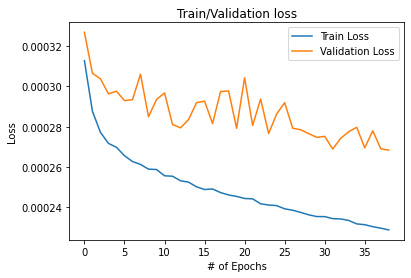

In [ ]:
plt.plot(loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.title('Train/Validation loss')
plt.show()

#### **Test the model**

In [ ]:
# Take a random song from the test set
test_1 = DataLoader(musdb_dataset_test, batch_size=1, shuffle=True)
sample = next(iter(test_1))
sample['mixture_mag'].shape, sample['vocals_mag'].shape

(torch.Size([1, 2, 1025, 587]), torch.Size([1, 2, 1025, 587]))

In [ ]:
# Get model prediction
X = sample['mixture_mag'].to(device) 
model.eval()
with torch.no_grad():
  output = model(X)

##### **Mixture Audio**

In [ ]:
original_mix = create_audiosignal(sample['mixture'].squeeze(0).numpy(), sample['mixture_sr'])
original_mix.peak_normalize()
original_mix.embed_audio(display=False)

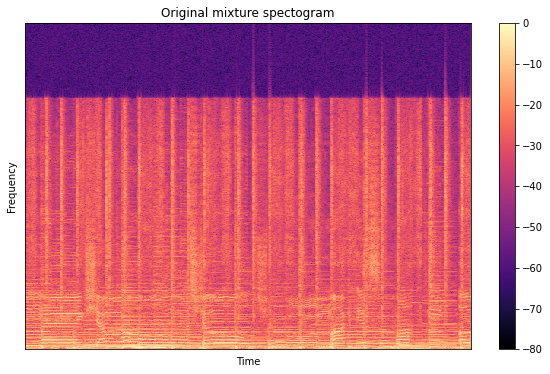

In [ ]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.power_to_db(np.abs(original_mix.stft_data)[:, :, 0], ref=np.max), sr=sample['mixture_sr'])
plt.colorbar()
plt.title('Original mixture spectogram')

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

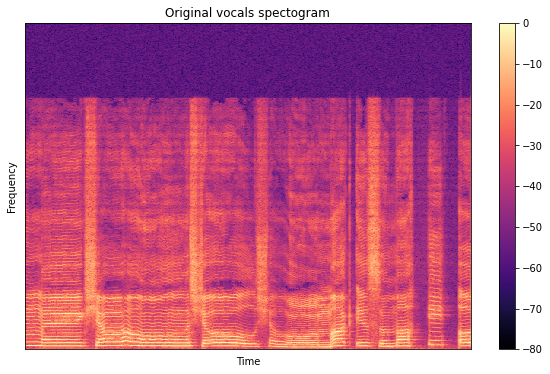

In [ ]:
original_vocals = create_audiosignal(sample['vocals'].squeeze(0).numpy(), sample['mixture_sr'])

plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.power_to_db(np.abs(original_vocals.stft_data)[:, :, 0], ref=np.max), sr=sample['mixture_sr'])
plt.colorbar()
plt.title('Original vocals spectogram')

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

##### **Model estimation**

In [ ]:
est = create_audiosignal(apply_mask_on_stft(sample['mixture'].squeeze(0).numpy(), output['mask'].squeeze(0).cpu().detach().numpy()), sample['mixture_sr'])
est.peak_normalize()
est.embed_audio(display=False)

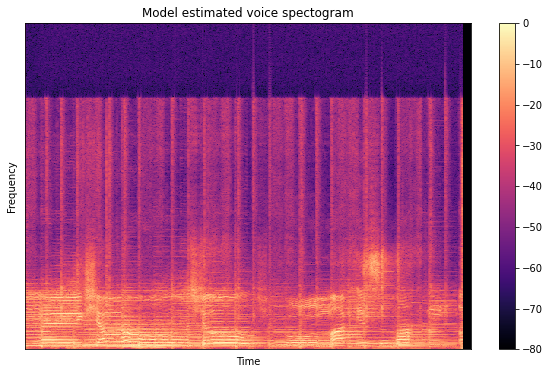

In [ ]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.power_to_db(np.abs(est.stft_data)[:, :, 0], ref=np.max), sr=sample['mixture_sr'])
plt.colorbar()
plt.title('Model estimated voice spectogram')

plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

##### **Spleeter Deezer**


In [ ]:
original_mix = create_audiosignal(sample['mixture'].squeeze(0).numpy(), sample['mixture_sr'])
original_mix.peak_normalize()
separator = Separator('spleeter:2stems')
sepertation_answer = separator.separate(original_mix.audio_data.T)

In [ ]:
spleeter_answer = nussl.AudioSignal(audio_data_array=sepertation_answer['vocals'], sample_rate=sample['mixture_sr'])
spleeter_answer.peak_normalize()
spleeter_answer.embed_audio(display=False)

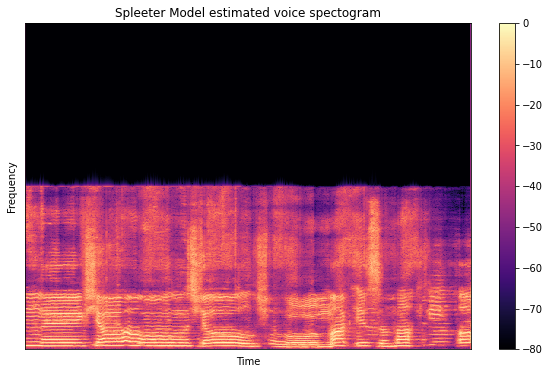

In [ ]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.power_to_db(np.abs(librosa.stft(sepertation_answer['vocals'][:, 0])), ref=np.max), sr=sample['mixture_sr'])
plt.colorbar()
plt.title('Spleeter Model estimated voice spectogram')

plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

##### **Metrics SI-SNR/SI-SDR**

In [ ]:
# Model estimation
est_torch = torch.from_numpy(preprocess_waveforms(est.audio_data.T)) 

# Original vocals
original_torch = create_audiosignal(sample['vocals'].squeeze(0).numpy(), sample['mixture_sr'])
original_torch = torch.from_numpy(preprocess_waveforms(original_mix.audio_data.T))

# Init metric models
si_snr = ScaleInvariantSignalNoiseRatio()
si_sdr = ScaleInvariantSignalDistortionRatio()

# Calculate metrics
si_snr_score = si_snr(est_torch, original_torch)
si_sdr_score = si_sdr(est_torch, original_torch)

si_snr_score, si_sdr_score

(tensor(122.7857), tensor(12.6348))

In [ ]:
# Metrics for Spleeter
spleeter_si_snr_score = si_snr(torch.from_numpy(preprocess_waveforms(sepertation_answer['vocals'])), original_torch)
spleeter_si_sdr_score = si_sdr(torch.from_numpy(preprocess_waveforms(sepertation_answer['vocals'])), original_torch)

spleeter_si_snr_score, spleeter_si_sdr_score

(tensor(36.8922), tensor(9.7915))

In [ ]:
score_object = {
    'SI-SNR': {
        'My_model': si_snr_score.item(),
        'Spleeter': spleeter_si_snr_score.item()
    },
    'SI-SDR': {
        'My_model': si_sdr_score.item(),
        'Spleeter': spleeter_si_sdr_score.item()
    }
}

pd.DataFrame(score_object)

,SI-SNR,SI-SDR
My_model,122.785713,12.634773
Spleeter,36.892208,9.791475


#### **More examples from the model**

In [ ]:
def get_model_example():
    # Take a random song from the test set
    test_1 = DataLoader(musdb_dataset_test, batch_size=1, shuffle=True)
    sample = next(iter(test_1))
    sample['mixture_mag'].shape, sample['vocals_mag'].shape

    # Get model prediction
    X = sample['mixture_mag'].to(device) 
    model.eval()
    with torch.no_grad():
      output = model(X)

    original_mix = create_audiosignal(sample['mixture'].squeeze(0).numpy(), sample['mixture_sr'])
    original_mix.peak_normalize()
    print('Original mixutre')
    original_mix.embed_audio(display=True)

    print('\n Model estimation')
    est = create_audiosignal(apply_mask_on_stft(sample['mixture'].squeeze(0).numpy(), output['mask'].squeeze(0).cpu().detach().numpy()), sample['mixture_sr'])
    est.peak_normalize()
    est.embed_audio(display=True)

In [ ]:
get_model_example()

Original mixutre



 Model estimation


In [ ]:
get_model_example()

Original mixutre



 Model estimation


In [ ]:
get_model_example()

Original mixutre



 Model estimation


In [ ]:
get_model_example()

Original mixutre



 Model estimation
